In [7]:
import re,string,warnings,torch,random,os,dataset,network,itertools,pickle
from tqdm import trange

from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, random_split
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
    

import numpy as np
import preprocessing as prep
from importlib import reload

reload(prep),reload(dataset),reload(network); 
import preprocessing as prep
import dataset,network

warnings.filterwarnings("ignore")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## DATASET

In [8]:
titles = ["the_chimes","david_copperfield","pickwick_papers"]
filepath = 'data/Dickens'

# Load all the books.

text = prep.loading(filepath=filepath,titles=titles)

# Preprocess the loaded texts.
cleared_text = prep.preprocessing(text)

Found letters: [' ', '0', '1', '2', '3', '4', '5', '7', '8', '9', ':', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [9]:
dataset_final = dataset.Dataset(text=cleared_text,load=True)

In [10]:
len_vocab = dataset_final.len_vocab()
print("Dimension Vocabolary : ", len_vocab)

Dimension Vocabolary :  19820


In [11]:
torch.manual_seed(1996)

training_size = int(0.9 * len(dataset_final))
test_size = len(dataset_final) - training_size
train_size = int(0.9 * training_size)
val_size = training_size - train_size

train_dataset, val_dataset, test_dataset = random_split(dataset_final, [train_size, val_size, test_size])


train_dataloader = DataLoader(train_dataset, batch_size = 512, drop_last=True,shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size = 512, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size = 512, drop_last=False)

print("Size full dataset : ", len(dataset_final))
print('_______________________________________________')
print('Size of training set:',len(train_dataset))
print('Size of validation set:',len(val_dataset))
print('Size of test set:',len(test_dataset))
print('_______________________________________________')


Size full dataset :  41459
_______________________________________________
Size of training set: 33581
Size of validation set: 3732
Size of test set: 4146
_______________________________________________


## NETWORK

Because the following cells have a very long execution time I suggest you to skip them, without executing them. 
You can directly load the best found model going to the section 2.3

### TRAINING: HYPERPARAMETER OPTIMIZATION 

In [ ]:
emb_dim=100
params_dict = {"hidden_units": [128,256],
               "layers_num":   [2,3],
               "optimizer" : ['torch.optim.Adamax',"torch.optim.AdamW"],
               "dropout_prob" : [0.2,0.3]
              }              
combinations = [dict(zip(params_dict.keys(), a)) for a in itertools.product(*params_dict.values())]
val_losses = []

for combination in trange(len(combinations)):
    net = network.Network(vocab_size=len_vocab, emb_dim=100, 
        hidden_units= combinations[combination]["hidden_units"], layers_num= combinations[combination]["layers_num"], 
                          dropout_prob= combinations[combination]["dropout_prob"], linear_size=512)
    net = net.to(device) 
    _,val_loss = net.trainin(train_dataloader=train_dataloader, test_dataloader=val_dataloader, 
        optimizer= combinations[combination]["optimizer"], n_epochs=200, early_stopping = [True,1], 
                             verbose = False, return_log=False)
    val_losses.append(val_loss)
ordered_list = sorted(zip(val_losses,combinations),reverse=False)
with open('./model/grid_search.data', 'wb') as filehandle:
    pickle.dump(ordered_list, filehandle)

### TRAINING: SELECTED HP. CLASS

In [6]:
with open('./model/grid_search.data', "rb") as input_file:
    load_results = pickle.load(input_file)
best_combination = load_results
print("BEST FOUND HP CLASS: \n",best_combination[0][1])

BEST FOUND HP CLASS: 
 {'hidden_units': 256, 'layers_num': 2, 'optimizer': 'torch.optim.Adamax', 'dropout_prob': 0.2}


In [7]:
torch.manual_seed(int(17))

training_size_1 = int(0.9 * len(dataset_final))
test_size_1 = len(dataset_final) - training_size_1

train_dataset_1, test_dataset_1 = random_split(dataset_final, [training_size_1,test_size_1])

train_dataloader_1 = DataLoader(train_dataset_1, batch_size = 512, drop_last=True,shuffle=True)
test_dataloader_1 = DataLoader(test_dataset_1, batch_size = 512, drop_last=False)


print('_______________________________________________')
print('Size of training set:',len(train_dataset_1))
print('Size of test set:',len(test_dataset_1))
print('_______________________________________________')

_______________________________________________
Size of training set: 37313
Size of test set: 4146
_______________________________________________


In [17]:
final_net = network.Network(vocab_size=len_vocab, emb_dim=100, 
        hidden_units= best_combination[0][1]["hidden_units"], layers_num= best_combination[0][1]["layers_num"], 
                          dropout_prob= best_combination[0][1]["dropout_prob"], linear_size=512)
final_net = final_net.to(device) 

In [37]:
train_loss_log,val_loss_log,_,val_loss = final_net.trainin(train_dataloader=train_dataloader_1, test_dataloader=test_dataloader_1,
                                    optimizer=  best_combination[0][1]["optimizer"], n_epochs=200, early_stopping = [True,1], verbose = False, return_log=True)

 72%|██████████████████████████████████████████████████████████                      | 145/200 [37:24<14:11, 15.48s/it]

EARLY STOPPED AT EPOCH :  145


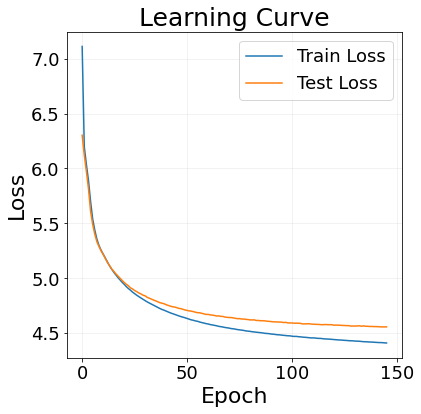

In [39]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(train_loss_log, label='Train Loss')
ax.plot(val_loss_log, label='Test Loss')
ax.set_ylabel("Loss",fontsize=22)
ax.set_xlabel("Epoch",fontsize=22)
ax.set_title('Learning Curve',fontsize=25)
ax.tick_params(labelsize=18)
ax.legend(fontsize=18)
ax.grid(alpha=0.2)

plt.savefig('learning_curve.png',bbox_inches="tight")

plt.show()

### LOADING AND PREDICTIONS

In [12]:
loaded_net = torch.load('./model/best_network.dat')
seed0 = 'Procrastination is the thief of time. Collar him.' # David Copperfield
np.random.seed(1)
loaded_net.generate_words(input_seed = seed0, n_words=50)

Procrastination is the thief of time. Collar him. by three, that i my aunt, with me. micawber, dry, more there s a fire after hounds of ladies errands scrutinised, and that ere, said committed that an affectionate countenance wearing, having likened desirous to render the stage girlish of that i

In [21]:
seed1 = 'So may the New Year be a happy one to you, happy to many more whose happiness depends on you.' # The Chimes
loaded_net.generate_words(input_seed = seed1, n_words=50)
np.random.seed(1)

So may the New Year be a happy one to you, happy to many more whose happiness depends on you. respond, when he called he. what mr. but he walked up tongs seeking your right of captain meekly untruth to say to be made me to be a son, that from which contagious winkle as we find there s odd a national informed mr. and